## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import h5py

## Exploring and Extracting Behavioral Data from Electrophysiology Paper

In [2]:
ephys_file = h5py.File("/Users/Devin Chang/Downloads/Chewie_CO_20150630.mat", 'r')
print(ephys_file.keys())

<KeysViewHDF5 ['#refs#', 'trial_data']>


In [3]:
print(ephys_file['trial_data'].keys())

<KeysViewHDF5 ['M1_lfp', 'M1_lfp_guide', 'M1_spikes', 'M1_unit_guide', 'bin_size', 'date_time', 'idx_endTime', 'idx_goCueTime', 'idx_movement_on', 'idx_startTime', 'idx_tgtOnTime', 'idx_trial_end', 'idx_trial_start', 'monkey', 'result', 'tgtDir', 'vel']>


In [4]:
behavioral_data_list = ['idx_endTime', 'idx_goCueTime', 'idx_movement_on', 'idx_startTime', 'idx_tgtOnTime', 'idx_trial_end', 'idx_trial_start']
behavioral_data_df = np.array([])
for info in behavioral_data_list:
    data = ephys_file['trial_data'][info]
    extracted_data = []
    for i in range(data.shape[0]):
        row_data = []
        for j in range(data.shape[1]):
            ref = data[i, j]  # Get the reference
            if isinstance(ref, h5py.Reference):  # Check if it's a reference
                actual_data = ephys_file[ref][()]  # Dereference and get data
                row_data.append(actual_data)
            else:
                row_data.append(ref)  # Directly append non-referenced data
        extracted_data.append(row_data)

    # Convert to a NumPy array and then to DataFrame (if applicable)
    np_data = np.array(extracted_data).reshape(178,)#, dtype=object)
    behavioral_data_df = np.hstack((behavioral_data_df, np_data))
behavioral_data_df = pd.DataFrame(behavioral_data_df.reshape(len(behavioral_data_list), 178).T, 
                                  columns=behavioral_data_list)

In [5]:
behavioral_data_df

,idx_endTime,idx_goCueTime,idx_movement_on,idx_startTime,idx_tgtOnTime,idx_trial_end,idx_trial_start
0,142.0,107.0,108.0,1.0,73.0,NaN,1.0
1,167.0,135.0,141.0,1.0,93.0,176.0,1.0
2,114.0,75.0,88.0,1.0,53.0,122.0,1.0
3,134.0,97.0,106.0,1.0,64.0,142.0,1.0
4,118.0,85.0,93.0,1.0,45.0,126.0,1.0
...,...,...,...,...,...,...,...
173,114.0,75.0,87.0,1.0,48.0,122.0,1.0
174,136.0,98.0,112.0,1.0,70.0,NaN,1.0
175,127.0,91.0,101.0,1.0,54.0,135.0,1.0
176,136.0,98.0,113.0,1.0,48.0,144.0,1.0


In [6]:
trial_starttime = np.array(behavioral_data_df['idx_startTime']) - 1
trial_endtime = np.array(behavioral_data_df['idx_endTime']) - 1
trial_movement_on = np.array(behavioral_data_df['idx_movement_on'])

## Preprocessing

In [7]:
with h5py.File("/Users/Devin Chang/Downloads/Chewie_CO_20150630.mat", 'r') as mat:
    data_list = []
    data = mat['trial_data']['M1_lfp']
    # Convert to NumPy array (MATLAB stores in column-major order, so transpose if needed)
    if isinstance(data[0, 0], h5py.Reference):
        # Extract actual data from references
        extracted_data = []
        for i in range(data.shape[0]):  # Iterate over rows
            row_data = []
            for j in range(data.shape[1]):  # Iterate over columns
                ref = data[i, j]  # Get the reference
                if isinstance(ref, h5py.Reference):  # Check if it's a reference
                    actual_data = mat[ref][()]  # Dereference and get data
                    row_data.append(actual_data)
                else:
                    row_data.append(ref)  # Directly append non-referenced data
            extracted_data.append(row_data)

        # Convert to a NumPy array and then to DataFrame (if applicable)
        np_data = extracted_data#, dtype=object)
        lfp_df = pd.DataFrame(np_data)

lfp_df_list = []
for i in range(lfp_df.shape[0]):
    lfp_df_list.append(pd.DataFrame(lfp_df[0][i]).T)

In [8]:
lfp_df_list[0]

,0,1,2,3,4,5,6,7,8,9,...,854,855,856,857,858,859,860,861,862,863
0,8.257605,42.878782,63.301639,1.283340,15.801977,31.863385,44.897776,72.045651,51.539563,15.346799,...,701.082675,14.753389,78.166445,61.154394,40.086982,54.929478,31.155542,31.057044,142.168923,27.141508
1,1.281180,42.859230,56.917981,2.666293,15.971701,46.606807,31.429457,67.583616,41.308509,6.611114,...,692.364498,14.902779,80.244602,58.463964,41.486497,76.598303,25.550656,31.547641,155.466928,27.080599
2,-7.685382,42.711337,55.778981,6.675004,16.990480,43.712009,46.306036,55.344703,38.607804,-1.384134,...,706.097289,13.522223,81.252464,50.661874,54.857652,104.199138,22.785694,43.015944,139.954524,21.760537
3,-10.719503,42.380179,54.586844,13.088107,19.931322,50.536605,68.939265,51.641724,35.171302,-3.401443,...,694.389221,17.627799,81.427882,49.364873,59.137833,126.691178,14.637440,50.244159,112.173875,21.220982
4,-5.274688,41.879501,44.956520,21.140904,20.355948,76.888430,74.356965,63.603587,35.040695,6.266364,...,704.748608,9.118808,81.356481,45.671050,68.260170,117.099163,12.486702,63.833741,92.023595,22.276900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,-15.950196,72.235273,27.111106,9.582767,22.616733,25.843046,36.013704,68.937066,24.007891,-30.653910,...,697.568048,13.501116,95.454146,34.019149,27.649677,183.150706,87.158863,71.174319,152.535457,38.811866
145,-16.506689,73.371396,32.477607,5.576015,25.991430,31.107557,45.646061,76.902404,33.498279,-25.344021,...,776.513179,23.958855,98.599920,48.387162,30.149217,163.138337,57.857841,76.932580,155.411646,29.714033
146,-9.366235,74.333296,34.125276,3.938636,24.622420,36.478300,47.978507,71.507306,32.556722,-13.786378,...,780.807683,28.026654,100.082653,54.397375,37.722513,118.382978,47.425274,67.600526,155.398468,23.152977
147,0.663022,74.671967,39.916477,2.346640,22.801099,49.223705,44.739138,57.394521,31.533487,-1.961522,...,756.102813,26.088976,99.513324,55.436849,36.898057,86.671525,43.442372,65.310640,156.483704,19.386516


In [9]:
num_trials = 10
num_neurons = 864

all_trials_lfp_list = []
y_labels_list = []
for i in range(num_trials):
    X = lfp_df_list[i]
    X = X.iloc[int(trial_starttime[i]):int(trial_endtime[i])]
    y = np.zeros(X.shape[0])
    y[int(trial_movement_on[i]):] = 1
    X = X.reset_index().drop(columns='index')
    y_labels_list.append(y)
    
    df_list = []
    for time in X.index:
        current_df = pd.DataFrame({'time':f"{i}_{time}", 'neuron':X.columns,
                                   'value': X.iloc[time, :]})
        df_list.append(current_df)
    long_df = pd.concat(df_list, ignore_index=True)
    all_trials_lfp_list.append(long_df)
all_trials_lfp_df = pd.concat(all_trials_lfp_list, ignore_index=True)
y_labels = np.concatenate(y_labels_list)

In [10]:
all_trials_lfp_df

,time,neuron,value
0,0_0,0,8.257605
1,0_0,1,42.878782
2,0_0,2,63.301639
3,0_0,3,1.283340
4,0_0,4,15.801977
...,...,...,...
1156027,9_128,859,101.711083
1156028,9_128,860,54.748275
1156029,9_128,861,112.671200
1156030,9_128,862,182.233188


## Feature Extraction

In [29]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

In [193]:
lfp_extracted_features = extract_features(all_trials_lfp_df, column_id="time", column_sort="neuron")

Feature Extraction: 100%|██████████| 20/20 [17:21<00:00, 52.07s/it]  


In [194]:
def sort_trialtime_index(df):
    df.index.name = "trial_time"
    df = df.reset_index()
    
    # Split the index into two numeric columns
    df[['trial', 'timepoint']] = df['trial_time'].str.split('_', expand=True).astype(int)
    
    # # Sort by trial number first, then by timepoint
    df = df.sort_values(by=['trial', 'timepoint']).set_index('trial_time')
    df.drop(columns=['trial', 'timepoint'], inplace=True)
    return df

In [195]:
lfp_extracted_features = sort_trialtime_index(lfp_extracted_features)
lfp_extracted_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
trial_time,,,,,,,,,,,,,,,,,,,,,
0_0,1.0,0.0,0.0,1.0,179863.639465,4.718772e+08,299.463099,0.021882,-0.086803,28.647364,...,1.008559,1.593593,3.608262,1.729595,3.002690,4.332025,5.427189,6.093998,NaN,5891.408664
0_1,1.0,0.0,0.0,1.0,176270.462634,4.647136e+08,297.625103,0.029895,-0.098587,27.785546,...,1.018960,1.642906,3.663004,1.730197,3.023658,4.397625,5.547516,6.207890,NaN,5897.684238
0_2,1.0,0.0,0.0,1.0,176241.704086,4.559302e+08,295.565171,0.034120,-0.097790,26.376279,...,1.039064,1.671091,3.587692,1.728896,3.020242,4.396342,5.571722,6.211278,NaN,5836.029362
0_3,1.0,0.0,0.0,1.0,178232.946812,4.671287e+08,301.474467,0.037011,-0.083557,27.655272,...,1.049065,1.672062,3.614363,1.736545,3.023630,4.341143,5.459496,6.104204,NaN,5886.652303
0_4,1.0,0.0,0.0,1.0,182807.724074,4.873059e+08,305.047361,0.031925,-0.067808,27.157183,...,1.064563,1.686568,3.651146,1.714756,2.973145,4.283847,5.389800,5.981048,NaN,5973.014858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_124,1.0,0.0,0.0,1.0,187388.805694,5.172071e+08,327.048164,0.028878,-0.129602,25.448432,...,0.921915,1.570819,3.571678,1.702530,2.958695,4.229939,5.307815,5.978975,NaN,6173.047046
9_125,1.0,0.0,0.0,1.0,190399.870241,5.339207e+08,331.904887,0.040737,-0.116441,27.049520,...,0.906585,1.562870,3.544358,1.722437,2.989076,4.269973,5.325566,5.968009,NaN,6313.212289
9_126,1.0,0.0,0.0,1.0,189531.105368,5.313467e+08,334.559408,0.053591,-0.108762,29.436189,...,0.857857,1.503992,3.514178,1.745152,2.978882,4.238757,5.262791,5.937783,NaN,6279.103544


In [196]:
# Drop NaN and impute missing values
lfp_extracted_features = impute(lfp_extracted_features)
lfp_selected_features = select_features(lfp_extracted_features, y_labels)

C:\Users\Devin Chang\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [197]:
lfp_selected_features

,"value__fft_coefficient__attr_""abs""__coeff_39","value__fft_coefficient__attr_""imag""__coeff_39",value__mean_change,"value__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","value__fft_coefficient__attr_""imag""__coeff_42","value__fft_coefficient__attr_""abs""__coeff_55","value__fft_coefficient__attr_""real""__coeff_10","value__fft_coefficient__attr_""real""__coeff_55","value__fft_coefficient__attr_""angle""__coeff_62","value__fft_coefficient__attr_""angle""__coeff_13",...,"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","value__fft_coefficient__attr_""abs""__coeff_51",value__partial_autocorrelation__lag_5,"value__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","value__fft_coefficient__attr_""angle""__coeff_35","value__fft_coefficient__attr_""abs""__coeff_82",value__fourier_entropy__bins_2,"value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""mean""","value__fft_coefficient__attr_""angle""__coeff_49","value__fft_coefficient__attr_""angle""__coeff_83"
trial_time,,,,,,,,,,,,,,,,,,,,,
0_0,18481.985140,18144.983087,0.021882,0.021882,13096.352249,9478.647922,6302.084616,-9451.301950,-142.565231,97.481786,...,75.896126,23274.786951,0.008882,75.836369,-42.451588,15874.747534,0.210883,8.490904,16.891029,-19.808911
0_1,18518.272516,18182.850685,0.029895,0.029895,12028.068734,9379.425112,6061.704257,-9365.612988,-142.693153,98.503155,...,67.684047,22448.233457,0.012077,74.813453,-48.973506,14724.697439,0.253037,8.293201,18.715592,-22.386367
0_2,19283.948707,18960.320720,0.034120,0.034120,11750.437403,10078.644092,5967.788880,-10077.440522,-141.597751,99.107387,...,68.677586,21995.292369,0.018109,88.952744,-55.621402,14177.110960,0.253037,8.283480,20.436399,-23.455424
0_3,20003.439741,19681.261654,0.037011,0.037011,12457.704208,10285.853790,6147.865678,-10285.708154,-140.163861,99.140297,...,59.259577,22715.119064,0.017511,103.871871,-57.980867,14388.829051,0.253037,8.374206,21.115205,-23.252363
0_4,21094.226401,20902.029182,0.031925,0.031925,13341.113547,10086.446693,6030.815463,-10085.607749,-140.169560,99.481885,...,62.062089,24009.124384,0.032335,120.083306,-59.049667,15243.311161,0.253037,8.614415,19.990792,-23.374351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_124,21564.331310,21030.845890,0.028878,0.028878,11133.722158,9745.621692,6366.761267,-9690.324000,-142.520736,98.862374,...,55.491381,24686.898298,-0.006235,51.242886,-44.752460,15248.151148,0.210883,8.746601,23.272822,-18.853501
9_125,22000.193958,21524.929250,0.040737,0.040737,11394.714548,10349.968806,7104.769186,-10341.064092,-140.456641,96.809678,...,71.567890,24279.122614,-0.006139,46.105359,-43.793714,15430.841571,0.210883,8.955031,22.803790,-15.742773
9_126,21549.835749,21226.392927,0.053591,0.053591,11422.129366,10303.034896,7181.878806,-10303.014322,-140.051613,96.640020,...,75.642988,23768.996785,-0.006956,53.504711,-46.726992,15213.601469,0.210883,8.932464,24.382447,-15.124306


In [12]:
# lfp_selected_features.to_csv('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/lfp_features.csv', index=True)
lfp_selected_features = pd.read_csv('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/tsfresh_feature_matrix/lfp_features.csv')
lfp_selected_features = lfp_selected_features.iloc[:, 1:]

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
lfp_normalized_features = scaler.fit_transform(lfp_selected_features)
lfp_normalized_features = pd.DataFrame(lfp_normalized_features, columns=lfp_selected_features.columns)
lfp_normalized_features

,"value__fft_coefficient__attr_""abs""__coeff_39","value__fft_coefficient__attr_""imag""__coeff_39",value__mean_change,"value__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","value__fft_coefficient__attr_""imag""__coeff_42","value__fft_coefficient__attr_""abs""__coeff_55","value__fft_coefficient__attr_""real""__coeff_10","value__fft_coefficient__attr_""real""__coeff_55","value__fft_coefficient__attr_""angle""__coeff_62","value__fft_coefficient__attr_""angle""__coeff_13",...,"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","value__fft_coefficient__attr_""abs""__coeff_51",value__partial_autocorrelation__lag_5,"value__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","value__fft_coefficient__attr_""angle""__coeff_35","value__fft_coefficient__attr_""abs""__coeff_82",value__fourier_entropy__bins_2,"value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""mean""","value__fft_coefficient__attr_""angle""__coeff_49","value__fft_coefficient__attr_""angle""__coeff_83"
0,-1.147695,-1.140738,-1.070894,-1.070894,-0.282831,-0.715752,-0.549771,0.555079,-1.072675,-0.676539,...,-0.730626,-1.033729,-0.553428,-0.886444,0.531292,0.483603,-0.231534,-1.057451,-1.286124,0.409907
1,-1.130384,-1.122978,-0.670096,-0.670096,-0.910247,-0.770902,-0.714258,0.599844,-1.088578,-0.414081,...,-1.081261,-1.442038,-0.494762,-0.912348,0.124249,0.019788,1.045148,-1.244138,-1.101060,-0.051901
2,-0.765122,-0.758331,-0.458758,-0.458758,-1.073303,-0.382263,-0.778522,0.227975,-0.952402,-0.258814,...,-1.038839,-1.665787,-0.383971,-0.554278,-0.290657,-0.201054,1.045148,-1.253317,-0.926521,-0.243446
3,-0.421892,-0.420198,-0.314182,-0.314182,-0.657916,-0.267092,-0.655300,0.119174,-0.774148,-0.250357,...,-1.440965,-1.310199,-0.394964,-0.176458,-0.437915,-0.115668,1.045148,-1.167647,-0.857670,-0.207063
4,0.098462,0.152362,-0.568546,-0.568546,-0.139079,-0.377926,-0.735394,0.223709,-0.774857,-0.162580,...,-1.321305,-0.670973,-0.122713,0.234088,-0.504620,0.228945,1.045148,-0.940822,-0.971718,-0.228920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.322724,0.212779,-0.720987,-0.720987,-1.435507,-0.567363,-0.505514,0.430210,-1.067143,-0.321774,...,-1.601857,-0.336159,-0.831056,-1.509262,0.387691,0.230896,-0.231534,-0.816003,-0.638825,0.581089
1334,0.530650,0.444512,-0.127833,-0.127833,-1.282223,-0.231456,-0.000513,0.090255,-0.810545,-0.849249,...,-0.915431,-0.537596,-0.829298,-1.639367,0.447528,0.304575,-0.231534,-0.619186,-0.686399,1.138444
1335,0.315809,0.304494,0.515113,0.515113,-1.266122,-0.257542,0.052252,0.110133,-0.760194,-0.892846,...,-0.741434,-0.789594,-0.844298,-1.451982,0.264457,0.216963,-0.231534,-0.640496,-0.526277,1.249256
1336,0.403375,0.438668,1.740648,1.740648,-1.797025,-0.541019,-0.577727,0.381850,-0.843318,-1.239161,...,-0.265494,-0.780156,-0.918504,-1.207897,0.214813,0.147782,-0.231534,-0.553714,-0.884040,1.388345


In [14]:
lfp_normalized_features.mean()

value__fft_coefficient__attr_"abs"__coeff_39                         -8.284355e-16
value__fft_coefficient__attr_"imag"__coeff_39                         1.455073e-15
value__mean_change                                                   -2.097641e-16
value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0    2.310060e-16
value__fft_coefficient__attr_"imag"__coeff_42                         1.115202e-15
                                                                          ...     
value__fft_coefficient__attr_"abs"__coeff_82                         -6.797419e-16
value__fourier_entropy__bins_2                                        1.306379e-15
value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"    1.688734e-15
value__fft_coefficient__attr_"angle"__coeff_49                       -6.160161e-16
value__fft_coefficient__attr_"angle"__coeff_83                        2.124194e-17
Length: 363, dtype: float64

In [15]:
# lfp_normalized_features.to_csv('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/normalized_lfp_features.csv', index=True)
lfp_normalized_features = pd.read_csv('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/tsfresh_feature_matrix/normalized_lfp_features.csv')
lfp_normalized_features = lfp_normalized_features.iloc[:, 1:]

## Classification with Random Forest Classifier

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [56]:
# Split into train and test sets
lfp_X_train, lfp_X_test, lfp_y_train, lfp_y_test = train_test_split(lfp_normalized_features, 
                                                                    y_labels, test_size=0.2, random_state=0, stratify=y_labels)

In [57]:
pd.Series(lfp_y_train).value_counts()

0.0    860
1.0    210
Name: count, dtype: int64

### Hyperparameter Tuning

In [109]:
clf_accuracies = []
train_errors, val_errors = [], []
lfp_class_weight = {0: 1, 1: 4}
num_estimators = np.arange(1, 300, 10)
for num in num_estimators:
    temp_clf = RandomForestClassifier(n_estimators=num, class_weight=lfp_class_weight, random_state=3)
    temp_clf.fit(lfp_X_train, lfp_y_train)
    temp_test_pred = temp_clf.predict(lfp_X_test)
    temp_train_pred = temp_clf.predict(lfp_X_train)
    clf_accuracies.append(accuracy_score(lfp_y_test, temp_test_pred))
    train_errors.append(1 - accuracy_score(lfp_y_train, temp_train_pred))
    val_errors.append(1 - accuracy_score(lfp_y_test, temp_test_pred))

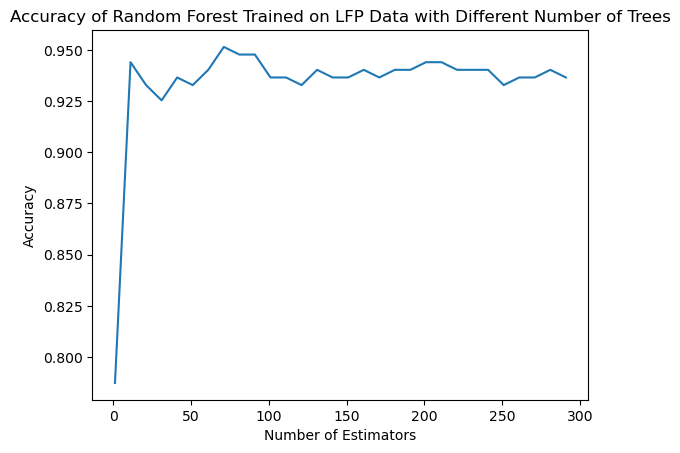

In [110]:
plt.plot(num_estimators, clf_accuracies)
plt.title('Accuracy of Random Forest Trained on LFP Data with Different Number of Trees')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.show()

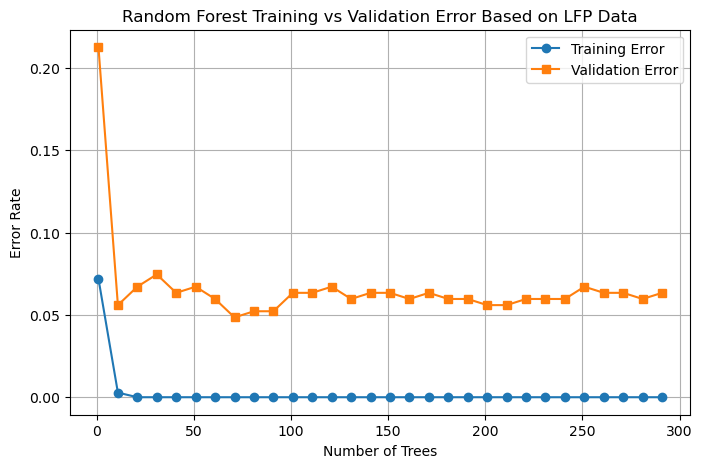

In [111]:
plt.figure(figsize=(8, 5))
plt.plot(num_estimators, train_errors, label="Training Error", marker='o')
plt.plot(num_estimators, val_errors, label="Validation Error", marker='s')
plt.xlabel("Number of Trees")
plt.ylabel("Error Rate")
plt.title("Random Forest Training vs Validation Error Based on LFP Data")
plt.legend()
plt.grid()
plt.show()

In [112]:
best_n_estimator = num_estimators[np.argmax(np.array([clf_accuracies]))]
best_n_estimator

71

### Model Training

In [61]:
# Train a Random Forest Classifier
lfp_rf_clf = RandomForestClassifier(n_estimators=135, class_weight=lfp_class_weight, random_state=0)
lfp_rf_clf.fit(lfp_X_train, lfp_y_train)
    
# Make predictions
lfp_y_pred = lfp_rf_clf.predict(lfp_X_test)

# Evaluate
print("Accuracy:", accuracy_score(lfp_y_test, lfp_y_pred))
print(classification_report(lfp_y_test, lfp_y_pred))

Accuracy: 0.9440298507462687
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97       215
         1.0       1.00      0.72      0.84        53

    accuracy                           0.94       268
   macro avg       0.97      0.86      0.90       268
weighted avg       0.95      0.94      0.94       268



# Calcium Imaging Dataset

## Loading Datasets

In [20]:
calcium_imaging_file = h5py.File('/Users/Devin Chang/Documents/Marmoset1/Marmoset1-data.mat', 'r')
print(calcium_imaging_file.keys())

<KeysViewHDF5 ['#refs#', 'roi', 'session_data']>


In [21]:
def make_idx_list(ser):
    return list(ser.dropna().apply(int))

In [22]:
roi_idx_df = pd.read_csv("/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/calcium_imaging_data/roi_idx.csv").set_index('label')
roi_idx_df['idx'] = roi_idx_df.apply(make_idx_list, axis=1)
roi_idx_df = roi_idx_df[['idx']]

In [23]:
roi_idx_df

,idx
label,
8aV,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 144, 145,..."
8b,"[108, 109, 171, 172, 173, 174, 175, 176, 234, ..."
8c,"[153, 154, 217, 218, 280, 281, 282, 343, 344, ..."
6Dr,"[38, 39, 91, 92, 93, 94, 95, 96, 97, 98, 99, 1..."
6Dc,"[602, 603, 604, 605, 664, 665, 666, 667, 668, ..."
6V,"[272, 273, 274, 275, 276, 277, 278, 336, 337, ..."
6M,"[496, 554, 555, 556, 557, 558, 559, 560, 618, ..."
4ab,"[1239, 1240, 1241, 1302, 1303, 1304, 1305, 130..."
4c,"[848, 912, 913, 914, 976, 977, 978, 979, 1040,..."


In [24]:
num_df = 10
calcium_imaging_df_list = []
calcium_imaging_folder = '/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/calcium_imaging_data'
for i in range(1, num_df + 1):
    df = pd.read_csv(calcium_imaging_folder + f'/trial_{i}.csv', header=None)
    calcium_imaging_df_list.append(df)

In [25]:
calcium_imaging_df_list[0]

,0,1,2,3,4,5,6,7,8,9,...,286,287,288,289,290,291,292,293,294,295
0,2.919705e-06,0.000002,0.000002,1.882468e-06,1.534436e-06,1.866604e-06,1.836362e-06,1.518441e-06,0.000002,1.427832e-06,...,1.743409e-07,5.305133e-07,2.884557e-07,3.565747e-07,1.984114e-07,3.736354e-07,5.815407e-07,2.904824e-07,4.237652e-07,4.411141e-07
1,-3.533586e-05,-0.000038,-0.000040,-3.371209e-05,-3.306586e-05,-3.254881e-05,-3.372005e-05,-3.407252e-05,-0.000032,-3.106179e-05,...,-3.749966e-06,-3.166592e-06,-6.123564e-06,-3.330290e-06,-1.484726e-06,6.837561e-07,4.108693e-06,8.999734e-06,6.593380e-06,6.518577e-06
2,-1.344078e-05,-0.000006,-0.000015,-9.995447e-06,-1.132800e-05,-1.189011e-05,-7.270114e-06,-9.712302e-06,-0.000007,-7.624892e-06,...,-1.676613e-06,-4.540027e-06,-1.374185e-06,3.587920e-07,-5.663967e-07,-5.561172e-06,-3.837139e-06,6.951782e-07,-1.204158e-06,-6.490919e-06
3,-3.441154e-06,-0.000009,-0.000004,-1.825091e-06,-4.640276e-06,-1.279701e-06,-9.647399e-07,-5.995730e-07,-0.000002,-4.587551e-06,...,-4.863314e-07,-3.221172e-06,-1.246747e-06,-5.091118e-07,-3.339409e-06,-1.216375e-06,-2.089731e-06,-2.778248e-06,-4.417034e-06,-4.803241e-06
4,1.034998e-07,0.000005,0.000002,5.469345e-07,4.603168e-07,-5.653084e-07,-8.153557e-08,-1.418958e-06,-0.000001,-1.471316e-07,...,-1.401968e-06,2.312425e-07,-1.302753e-06,-2.918739e-07,1.265286e-06,1.780763e-07,3.285432e-08,1.779186e-07,1.256659e-06,1.025105e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4092,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4093,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4094,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [26]:
ci_behavior_df = pd.read_excel('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/calcium_imaging_data/calcium_imaging_behavioral_trials.xlsx')
ci_behavior_df

,Trial,onset_cue,onset_pull,onset_push,success,trial_type,first_choice
0,1,100,-1,183,1,1,1
1,2,99,-1,152,1,1,1
2,3,101,-1,388,1,1,1
3,4,97,-1,168,1,1,1
4,5,96,-1,165,1,1,1
5,6,99,-1,136,1,1,1
6,7,102,-1,139,1,1,1
7,8,150,-1,198,1,1,1
8,9,100,-1,138,1,1,1
9,10,99,-1,142,1,1,1


## Data Preprocessing

In [27]:
M1_roi_idx = np.array(roi_idx_df.loc['4ab']['idx']) - 1
PMdc_roi_idx = np.array(roi_idx_df.loc['6Dc']['idx']) - 1
PMdr_roi_idx = np.array(roi_idx_df.loc['6Dr']['idx']) - 1

In [28]:
print(M1_roi_idx)

[1238 1239 1240 1301 1302 1303 1304 1305 1306 1307 1308 1309 1310 1311
 1312 1313 1314 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375
 1376 1377 1378 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389
 1390 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441
 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451 1452 1453 1454 1455
 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504 1505 1506
 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1557
 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571
 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1621 1622
 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636
 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1685 1686 1687
 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701
 1702 1703 1704 1705 1706 1707 1708 1709 1710 1711 1750 1751 1752 1753
 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765 1766 1767
 1768 

In [29]:
ci_M1_df_list = [] 
for data in calcium_imaging_df_list:
    data = data.loc[M1_roi_idx].T
    # data = data.drop(columns=['id'])
    ci_M1_df_list.append(data)
ci_M1_df_list[0]

,1238,1239,1240,1301,1302,1303,1304,1305,1306,1307,...,2286,2342,2343,2344,2345,2346,2347,2348,2349,2350
0,-0.397130,-0.653119,-0.829642,-0.237469,-0.545765,-0.593284,-0.585078,-0.701838,-0.723307,-0.659907,...,-0.660166,-0.628794,-0.584169,-0.505326,-0.792260,-0.951849,-1.263783,-1.079828,-0.911253,-0.888962
1,-0.473834,-0.740661,-0.927336,-0.312852,-0.637405,-0.692798,-0.694614,-0.790996,-0.808154,-0.773173,...,-0.425994,-0.798146,-0.718317,-0.625794,-0.983194,-1.172341,-1.427082,-1.286168,-1.176788,-1.181069
2,-0.660657,-0.900975,-1.096124,-0.473538,-0.811514,-0.874250,-0.847355,-0.955417,-1.011256,-0.993379,...,-0.907777,-0.994433,-0.897538,-0.786983,-1.136560,-1.334228,-1.640163,-1.517312,-1.331130,-0.883874
3,-0.665365,-0.870937,-1.025627,-0.476715,-0.802048,-0.862595,-0.814823,-0.890919,-0.949035,-0.953278,...,-1.432244,-0.903004,-0.815966,-0.728043,-1.075401,-1.324848,-1.569223,-1.423839,-1.279348,-1.273397
4,-0.386687,-0.610903,-0.723226,-0.196402,-0.442993,-0.547433,-0.551416,-0.599971,-0.655308,-0.647794,...,-0.359641,-0.616732,-0.532697,-0.488219,-0.893803,-1.112789,-1.317984,-1.153778,-0.928276,-0.625688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,0.168888,0.356962,0.298350,-0.039746,0.310585,0.373754,0.354586,0.315539,0.266251,0.253512,...,-0.305301,-0.506602,-0.286834,-0.174327,-0.324650,-0.259279,-0.367385,-0.384704,-0.384616,-0.092873
292,0.333215,0.495604,0.428269,0.203875,0.495434,0.526268,0.503897,0.435872,0.368246,0.374198,...,0.115647,-0.397771,-0.217740,-0.093731,-0.147775,-0.079861,-0.264057,-0.255179,-0.173734,0.194228
293,0.683110,0.829113,0.734896,0.601391,0.834797,0.811999,0.744044,0.679031,0.609262,0.597736,...,0.216134,-0.242291,-0.074396,0.102053,0.142143,0.186825,0.036203,0.014927,0.023112,0.132133
294,0.645374,0.777535,0.700724,0.694264,0.852684,0.769015,0.736064,0.677237,0.602074,0.594615,...,0.018170,-0.212634,-0.096152,0.065065,0.141888,0.153020,0.011182,0.034871,-0.043173,-0.076007


In [30]:
trial_push_onset = list(ci_behavior_df['onset_push'])

y_list = []
for i in range(len(trial_push_onset)):
    temp_df = ci_M1_df_list[i]
    y = np.zeros(temp_df.shape[0])
    y[trial_push_onset[i]:] = 1
    y_list.append(y)

In [31]:
y_list[0].shape

(296,)

In [32]:
ci_y = np.concatenate(y_list)
ci_y.shape

(2939,)

In [33]:
ci_M1_df_list[0].index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295],
      dtype='int64', length=296)

In [34]:
ci_long_df = pd.DataFrame()
for i in range(len(ci_M1_df_list)):
    temp_df = ci_M1_df_list[i].copy()
    temp_df['time'] = [f'{i}_{j}' for j in temp_df.index]
    temp_df = temp_df.melt(id_vars='time', var_name='neuron').sort_values(['time', 'neuron'])
    temp_df = temp_df.reset_index(drop=True)
    ci_long_df = pd.concat([ci_long_df, temp_df])

In [35]:
ci_long_df

,time,neuron,value
0,0_0,1238,-0.397130
1,0_0,1239,-0.653119
2,0_0,1240,-0.829642
3,0_0,1301,-0.237469
4,0_0,1302,-0.545765
...,...,...,...
89688,9_99,2346,-0.011640
89689,9_99,2347,0.595066
89690,9_99,2348,0.291546
89691,9_99,2349,-0.092351


## Feature Extraction

In [78]:
ci_extracted_features = extract_features(ci_long_df, column_id="time", column_sort="neuron")

Feature Extraction: 100%|██████████| 20/20 [07:27<00:00, 22.39s/it]


In [285]:
ci_extracted_features = sort_trialtime_index(ci_extracted_features)
ci_extracted_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
trial_time,,,,,,,,,,,,,,,,,,,,,
0_0,0.0,0.0,0.0,0.0,-190.946543,148.264282,0.122732,-0.001413,0.000401,-0.545765,...,0.125256,0.245901,0.758735,1.538338,2.530560,3.561471,4.432334,4.959156,NaN,1.356765
0_1,0.0,0.0,0.0,0.0,-227.074475,196.102071,0.125873,-0.002032,0.000378,-0.670598,...,0.170467,0.290926,0.900707,1.581231,2.630837,3.703101,4.581758,5.102051,NaN,1.459515
0_2,0.0,0.0,0.0,0.0,-298.549994,314.900912,0.136633,-0.000641,0.000991,-0.867324,...,0.159721,0.280179,0.874730,1.571916,2.635557,3.672020,4.486323,5.027785,NaN,1.792053
0_3,0.0,0.0,0.0,0.0,-295.446220,310.733452,0.134829,-0.001747,0.000305,-0.818003,...,0.125256,0.262742,0.721018,1.530051,2.531014,3.534701,4.335691,4.856844,NaN,1.824288
0_4,0.0,0.0,0.0,0.0,-183.294170,147.226814,0.118931,-0.000687,0.000759,-0.490558,...,0.125256,0.288307,0.664454,1.540506,2.534724,3.510821,4.325984,4.853456,NaN,1.415360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_252,0.0,0.0,0.0,0.0,-136.143097,118.990973,0.136343,-0.000403,-0.000292,-0.504185,...,0.079983,0.159721,0.599109,1.553390,2.570173,3.582802,4.405696,4.988025,NaN,1.116540
9_253,0.0,0.0,0.0,0.0,-204.059288,184.138219,0.126287,-0.000991,-0.000690,-0.721755,...,0.079983,0.136002,0.538224,1.553181,2.551493,3.547135,4.379514,4.941925,NaN,1.278767
9_254,0.0,0.0,0.0,0.0,-117.204342,113.357654,0.140089,0.000683,0.000108,-0.466130,...,0.079983,0.090729,0.524242,1.545239,2.543740,3.518401,4.291713,4.871929,NaN,1.071071


In [291]:
# Drop NaN and impute missing values
ci_extracted_features = impute(ci_extracted_features)
ci_selected_features = select_features(ci_extracted_features, ci_y)

C:\Users\Devin Chang\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [297]:
ci_selected_features

,"value__fft_coefficient__attr_""real""__coeff_88","value__fft_coefficient__attr_""real""__coeff_14",value__quantile__q_0.6,value__quantile__q_0.3,value__quantile__q_0.7,value__quantile__q_0.4,"value__fft_coefficient__attr_""real""__coeff_0",value__sum_values,value__mean,value__quantile__q_0.2,...,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,"value__fft_coefficient__attr_""real""__coeff_9","value__fft_coefficient__attr_""abs""__coeff_65","value__fft_coefficient__attr_""imag""__coeff_55","value__fft_coefficient__attr_""imag""__coeff_95","value__fft_coefficient__attr_""abs""__coeff_40","value__fft_coefficient__attr_""abs""__coeff_38",value__autocorrelation__lag_9,"value__fft_coefficient__attr_""real""__coeff_66","value__fft_coefficient__attr_""abs""__coeff_21"
0,2.268127,-20.441207,-0.435836,-0.736603,-0.334859,-0.648651,-190.946543,-190.946543,-0.547125,-0.846819,...,0.094079,-5.786343,4.948871,1.374989,2.596943,5.301305,6.478599,-0.183254,-1.260011,15.114901
1,1.715622,-21.292286,-0.559697,-0.854790,-0.439815,-0.768182,-227.074475,-227.074475,-0.650643,-0.949605,...,0.092149,-5.983444,6.035009,1.604087,3.321784,7.619099,6.432284,-0.098976,0.302901,16.016765
2,0.641241,-23.695706,-0.752270,-1.048536,-0.619330,-0.943825,-298.549994,-298.549994,-0.855444,-1.220350,...,0.086108,-7.734501,5.495877,0.883707,3.133606,8.433664,4.860973,-0.072699,0.330397,16.799892
3,0.652416,-22.884645,-0.719552,-1.036899,-0.583202,-0.912250,-295.446220,-295.446220,-0.846551,-1.252288,...,0.091661,-5.320974,5.412535,-0.028148,4.659993,5.091687,3.457897,-0.184866,-1.111360,18.015376
4,0.789806,-18.054874,-0.383160,-0.743401,-0.307204,-0.610912,-183.294170,-183.294170,-0.525198,-0.851053,...,0.073602,-4.003717,5.132588,1.156900,4.106513,6.286019,3.087868,-0.100930,1.106105,16.884683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,-3.340964,31.634166,-0.397709,-0.658698,-0.202313,-0.582953,-136.143097,-136.143097,-0.390095,-0.764786,...,0.043756,-0.375105,5.626063,2.451323,-1.636084,8.162772,4.339074,0.010967,2.094812,8.188007
2935,-2.690694,32.151146,-0.627348,-0.856084,-0.453627,-0.787029,-204.059288,-204.059288,-0.584697,-0.917863,...,0.070037,-0.602633,5.486471,2.048819,-2.346120,6.245224,5.021566,-0.032765,-0.092246,6.518158
2936,-3.364630,35.274095,-0.362113,-0.635512,-0.138494,-0.551062,-117.204342,-117.204342,-0.335829,-0.718340,...,0.072926,0.535822,4.732717,4.427644,-2.696202,4.572092,4.528072,-0.071866,-0.637522,6.543445
2937,-3.102582,32.113369,-0.174180,-0.442459,0.053821,-0.344358,-45.199750,-45.199750,-0.129512,-0.538932,...,0.086846,0.270296,4.447499,4.958129,-0.053222,5.138750,1.948757,-0.039501,2.142770,4.200533


In [36]:
# ci_selected_features.to_csv('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/ci_features.csv', index=True)
ci_selected_features = pd.read_csv('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/tsfresh_feature_matrix/ci_features.csv')
ci_selected_features = ci_selected_features.iloc[:, 1:]

In [37]:
scaler = StandardScaler()
ci_normalized_features = scaler.fit_transform(ci_selected_features)
ci_normalized_features = pd.DataFrame(ci_normalized_features, columns=ci_selected_features.columns)
ci_normalized_features

,"value__fft_coefficient__attr_""real""__coeff_88","value__fft_coefficient__attr_""real""__coeff_14",value__quantile__q_0.6,value__quantile__q_0.3,value__quantile__q_0.7,value__quantile__q_0.4,"value__fft_coefficient__attr_""real""__coeff_0",value__sum_values,value__mean,value__quantile__q_0.2,...,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,"value__fft_coefficient__attr_""real""__coeff_9","value__fft_coefficient__attr_""abs""__coeff_65","value__fft_coefficient__attr_""imag""__coeff_55","value__fft_coefficient__attr_""imag""__coeff_95","value__fft_coefficient__attr_""abs""__coeff_40","value__fft_coefficient__attr_""abs""__coeff_38",value__autocorrelation__lag_9,"value__fft_coefficient__attr_""real""__coeff_66","value__fft_coefficient__attr_""abs""__coeff_21"
0,0.940624,-0.839666,-0.247453,-0.263753,-0.254199,-0.266304,-0.288328,-0.288328,-0.288328,-0.282731,...,-0.213932,-1.920979,-0.124682,0.383348,1.323290,-0.195151,0.176566,-0.499917,-0.220138,0.625947
1,0.702641,-0.882770,-0.376824,-0.397139,-0.361369,-0.397151,-0.400669,-0.400669,-0.400669,-0.402807,...,-0.265034,-1.982540,0.198988,0.451965,1.687918,0.454091,0.160919,-0.004684,0.539241,0.759595
2,0.239866,-1.004494,-0.577963,-0.615800,-0.544673,-0.589422,-0.622925,-0.622925,-0.622925,-0.719095,...,-0.425036,-2.529452,0.038326,0.236203,1.593256,0.682260,-0.369922,0.149723,0.552601,0.875648
3,0.244680,-0.963416,-0.543790,-0.602666,-0.507783,-0.554858,-0.613273,-0.613273,-0.613273,-0.756406,...,-0.277965,-1.775629,0.013490,-0.036908,2.361097,-0.253868,-0.843928,-0.509391,-0.147912,1.055772
4,0.303859,-0.718807,-0.192434,-0.271425,-0.225960,-0.224993,-0.264533,-0.264533,-0.264533,-0.287676,...,-0.756255,-1.364207,-0.069934,0.318028,2.082672,0.080679,-0.968936,-0.016165,0.929497,0.888213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,-1.475412,1.797751,-0.207631,-0.175830,-0.118855,-0.194386,-0.117915,-0.117915,-0.117915,-0.186899,...,-1.546706,-0.230875,0.077122,0.705723,-0.806116,0.606380,-0.546237,0.641363,1.409884,-0.400558
2935,-1.195317,1.823934,-0.447484,-0.398599,-0.375473,-0.417783,-0.329103,-0.329103,-0.329103,-0.365726,...,-0.850677,-0.301939,0.035523,0.585168,-1.163296,0.069252,-0.315669,0.384387,0.347249,-0.648015
2936,-1.485605,1.982100,-0.170451,-0.149662,-0.053689,-0.159476,-0.059024,-0.059024,-0.059024,-0.132640,...,-0.774161,0.053637,-0.189096,1.297654,-1.339403,-0.399412,-0.482387,0.154620,0.082314,-0.644268
2937,-1.372732,1.822021,0.025841,0.068216,0.142685,0.066796,0.164876,0.164876,0.164876,0.076947,...,-0.405497,-0.029295,-0.274091,1.456541,-0.009864,-0.240685,-1.353765,0.344802,1.433186,-0.991467


In [38]:
# ci_normalized_features.to_csv('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/normalized_ci_features.csv', index=True)
ci_normalized_features = pd.read_csv('/Users/Devin Chang/Documents/BIPN162/BIPN162_Cell_Types/tsfresh_feature_matrix/normalized_ci_features.csv')
ci_normalized_features = ci_normalized_features.iloc[:, 1:]

In [39]:
ci_normalized_features.mean()

value__fft_coefficient__attr_"real"__coeff_88    0.000000e+00
value__fft_coefficient__attr_"real"__coeff_14   -2.901161e-17
value__quantile__q_0.6                           3.868215e-17
value__quantile__q_0.3                          -2.417634e-17
value__quantile__q_0.7                          -2.901161e-17
                                                     ...     
value__fft_coefficient__attr_"abs"__coeff_40     1.063759e-16
value__fft_coefficient__attr_"abs"__coeff_38     4.255036e-16
value__autocorrelation__lag_9                    1.934107e-17
value__fft_coefficient__attr_"real"__coeff_66   -3.384688e-17
value__fft_coefficient__attr_"abs"__coeff_21     3.868215e-17
Length: 593, dtype: float64

## Training Random Forest Classifier

In [40]:
# Split into train and test sets
ci_X_train, ci_X_test, ci_y_train, ci_y_test = train_test_split(ci_normalized_features, 
                                                                    ci_y, test_size=0.2, random_state=2, stratify=ci_y)

In [41]:
pd.Series(ci_y_train).value_counts()

0.0    1447
1.0     904
Name: count, dtype: int64

### Hyperparameter Optimization

In [106]:
clf_accuracies = []
train_errors, val_errors = [], []
ci_class_weight = {0: 1, 1: 1.6}
num_estimators = np.arange(1, 300, 10)
for num in num_estimators:
    temp_clf = RandomForestClassifier(n_estimators=num, class_weight=ci_class_weight, random_state=1)
    temp_clf.fit(ci_X_train, ci_y_train)
    temp_test_pred = temp_clf.predict(ci_X_test)
    temp_train_pred = temp_clf.predict(ci_X_train)
    clf_accuracies.append(accuracy_score(ci_y_test, temp_test_pred))
    train_errors.append(1 - accuracy_score(ci_y_train, temp_train_pred))
    val_errors.append(1 - accuracy_score(ci_y_test, temp_test_pred))

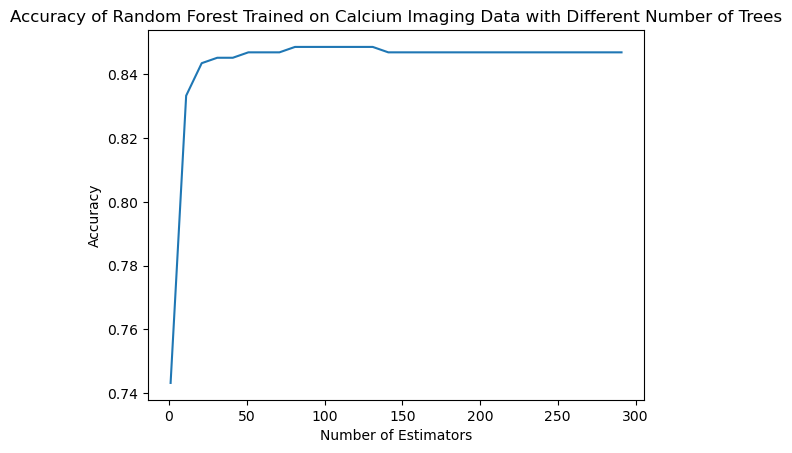

In [107]:
plt.plot(num_estimators, clf_accuracies)
plt.title('Accuracy of Random Forest Trained on Calcium Imaging Data with Different Number of Trees')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.show()

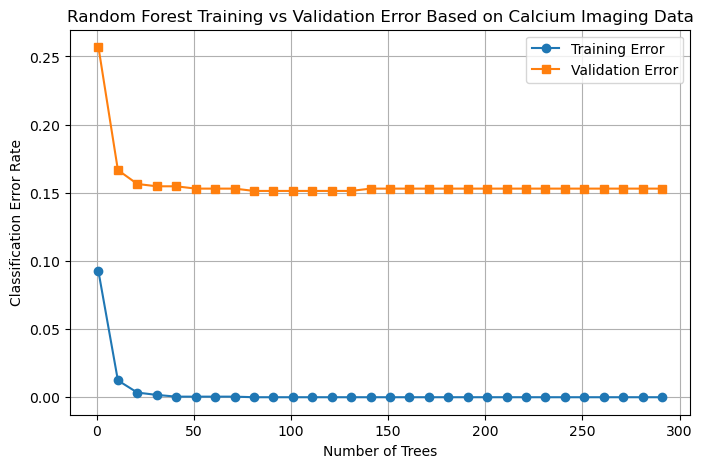

In [108]:
plt.figure(figsize=(8, 5))
plt.plot(num_estimators, train_errors, label="Training Error", marker='o')
plt.plot(num_estimators, val_errors, label="Validation Error", marker='s')
plt.xlabel("Number of Trees")
plt.ylabel("Classification Error Rate")
plt.title("Random Forest Training vs Validation Error Based on Calcium Imaging Data")
plt.legend()
plt.grid()
plt.show()

In [113]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter distributions
param_dist = {
    'n_estimators': np.arange(1, 300, 10),
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform Randomized Search
rf = RandomForestClassifier(class_weight=ci_class_weight, random_state=0)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=0)
random_search.fit(ci_X_train, ci_y_train)

# Best parameters
print(f"Best Hyperparameters: {random_search.best_params_}")

Best Hyperparameters: {'n_estimators': 211, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}


In [115]:
# Store training and validation scores
train_scores = []
val_scores = []

# Evaluate each model from the random search
for params in random_search.cv_results_['params']:
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(ci_X_train, ci_y_train)
    
    train_acc = accuracy_score(ci_y_train, model.predict(ci_X_train))
    val_acc = accuracy_score(ci_y_test, model.predict(ci_X_test))
    
    train_scores.append(1 - train_acc)  # Convert accuracy to error
    val_scores.append(1 - val_acc)  # Convert accuracy to error

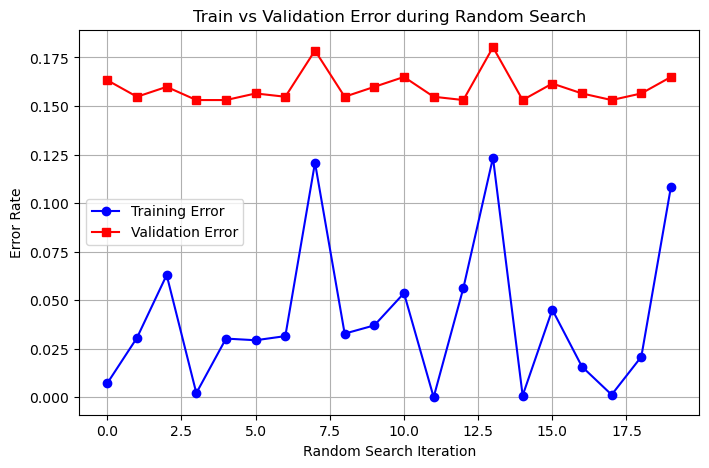

In [116]:
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_scores)), train_scores, marker='o', label="Training Error", color="blue")
plt.plot(range(len(val_scores)), val_scores, marker='s', label="Validation Error", color="red")
plt.xlabel("Random Search Iteration")
plt.ylabel("Error Rate")
plt.title("Train vs Validation Error during Random Search")
plt.legend()
plt.grid()
plt.show()

### Model Training

In [ ]:
ci_class_weight = {0: 1, 1: 1.6}
# Train a Random Forest Classifier
ci_rf_clf = RandomForestClassifier(n_estimators=100, class_weight=ci_class_weight, random_state=2)
ci_rf_clf.fit(ci_X_train, ci_y_train)
    
# Make predictions
ci_y_pred = ci_rf_clf.predict(ci_X_test)

# Evaluate
print("Accuracy:", accuracy_score(ci_y_test, ci_y_pred))
print(classification_report(ci_y_test, ci_y_pred))

## Plots

## Confusion Matrices

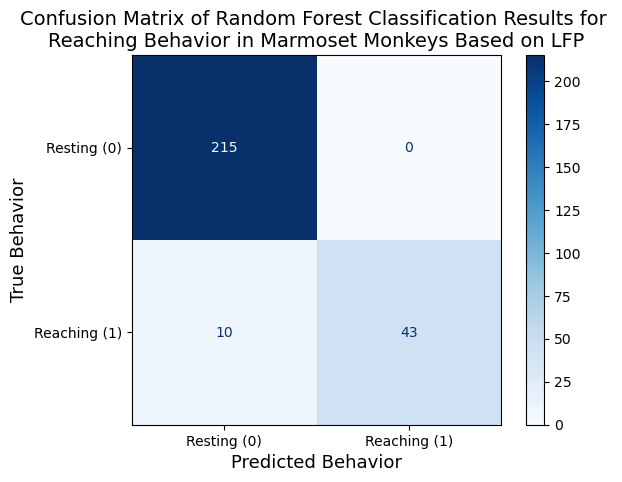

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_1 = confusion_matrix(lfp_y_test, lfp_y_pred)
display_cm_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1)
display_cm_1.plot(cmap='Blues')
plt.xlabel('Predicted Behavior', fontsize=13)
plt.ylabel('True Behavior', fontsize=13)
plt.xticks([0, 1], ['Resting (0)', 'Reaching (1)'], fontsize=10)
plt.yticks([0, 1], ['Resting (0)', 'Reaching (1)'], fontsize=10)
plt.title('Confusion Matrix of Random Forest Classification Results for \nReaching Behavior in Marmoset Monkeys Based on LFP', fontsize=14)
plt.show()

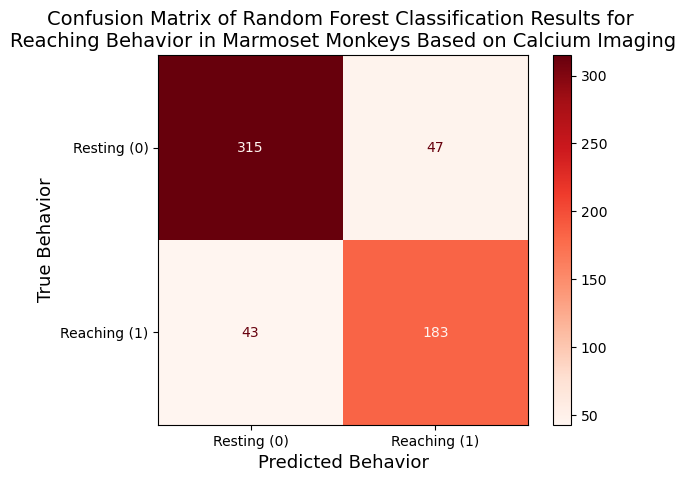

In [44]:
cm_2 = confusion_matrix(ci_y_test, ci_y_pred)
display_cm_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
display_cm_2.plot(cmap='Reds')
plt.xlabel('Predicted Behavior', fontsize=13)
plt.ylabel('True Behavior', fontsize=13)
plt.xticks([0, 1], ['Resting (0)', 'Reaching (1)'], fontsize=10)
plt.yticks([0, 1], ['Resting (0)', 'Reaching (1)'], fontsize=10)
plt.title('Confusion Matrix of Random Forest Classification Results for \nReaching Behavior in Marmoset Monkeys Based on Calcium Imaging', fontsize=14)
plt.show()

## ROC-AUC

In [45]:
lfp_y_pred_prob = lfp_rf_clf.predict_proba(lfp_X_test)[:, 1]
ci_y_pred_prob = ci_rf_clf.predict_proba(ci_X_test)[:, 1]
print(lfp_y_pred_prob.shape)
print(ci_y_pred_prob.shape)

(268,)
(588,)


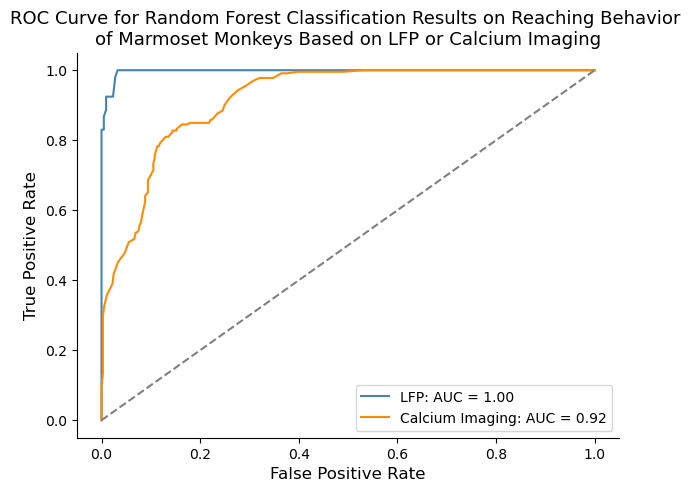

In [46]:
from sklearn.metrics import roc_curve, auc

fpr_1, tpr_1, _ = roc_curve(lfp_y_test, lfp_y_pred_prob)
fpr_2, tpr_2, _ = roc_curve(ci_y_test, ci_y_pred_prob)
roc_auc_1 = auc(fpr_1, tpr_1)
roc_auc_2 = auc(fpr_2, tpr_2)

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(fpr_1, tpr_1, label=f'LFP: AUC = {roc_auc_1:.2f}', color='#4682B4')
plt.plot(fpr_2, tpr_2, label=f'Calcium Imaging: AUC = {roc_auc_2:.2f}', color='#FF8C00')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random model
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("ROC Curve for Random Forest Classification Results on Reaching Behavior \nof Marmoset Monkeys Based on LFP or Calcium Imaging", fontsize=13)
plt.legend()
plt.show()


## PR Curve

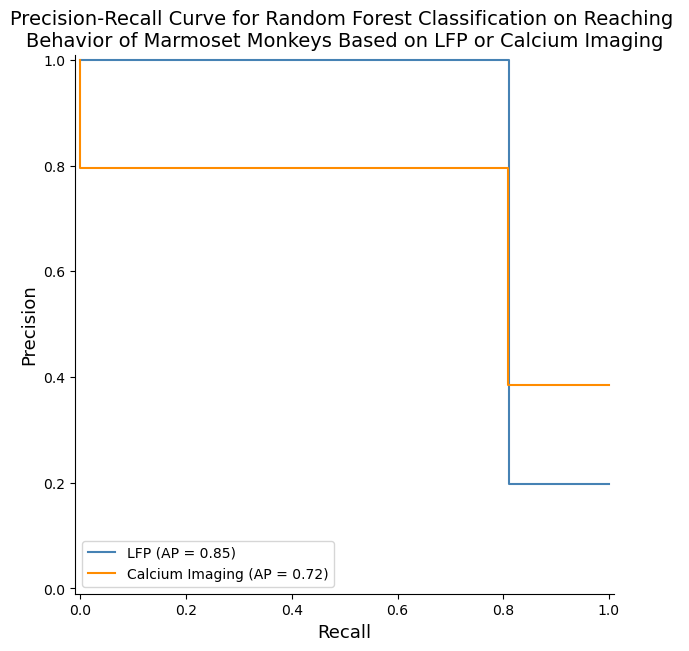

In [47]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(8, 7))
PrecisionRecallDisplay.from_predictions(lfp_y_test, lfp_y_pred, ax=ax, name='LFP', color='#4682B4')
PrecisionRecallDisplay.from_predictions(ci_y_test, ci_y_pred, ax=ax, name='Calcium Imaging', color='#FF8C00')
plt.xlabel("Recall", fontsize=13)
plt.ylabel("Precision", fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("Precision-Recall Curve for Random Forest Classification on Reaching \nBehavior of Marmoset Monkeys Based on LFP or Calcium Imaging", fontsize=14)
plt.show()

## Feature Importance

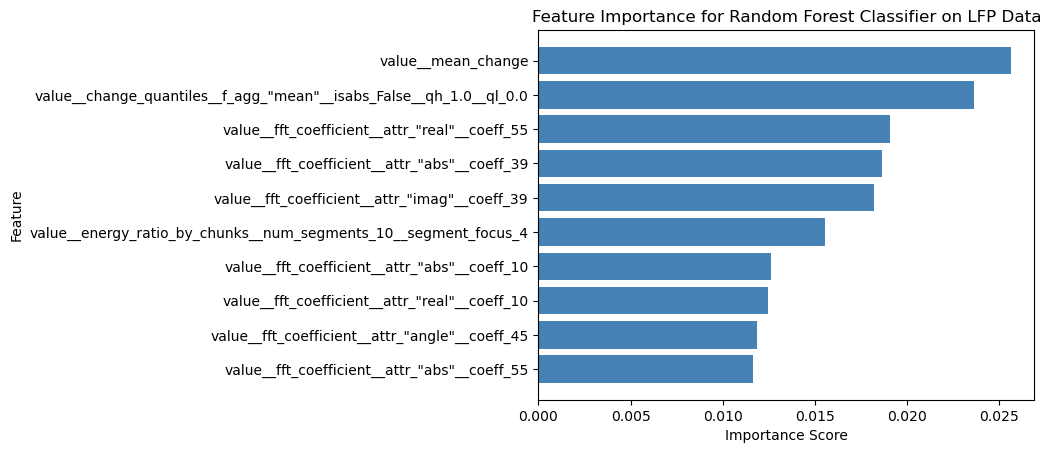

In [48]:
import numpy as np

lfp_features = lfp_normalized_features.columns
lfp_importances = lfp_rf_clf.feature_importances_
lfp_indices = np.argsort(lfp_importances)

plt.barh(range(len(lfp_indices))[-10:], lfp_importances[lfp_indices][-10:], color='#4682B4')
plt.yticks(range(len(lfp_indices))[-10:], [lfp_features[i] for i in lfp_indices][-10:])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest Classifier on LFP Data")
plt.show()

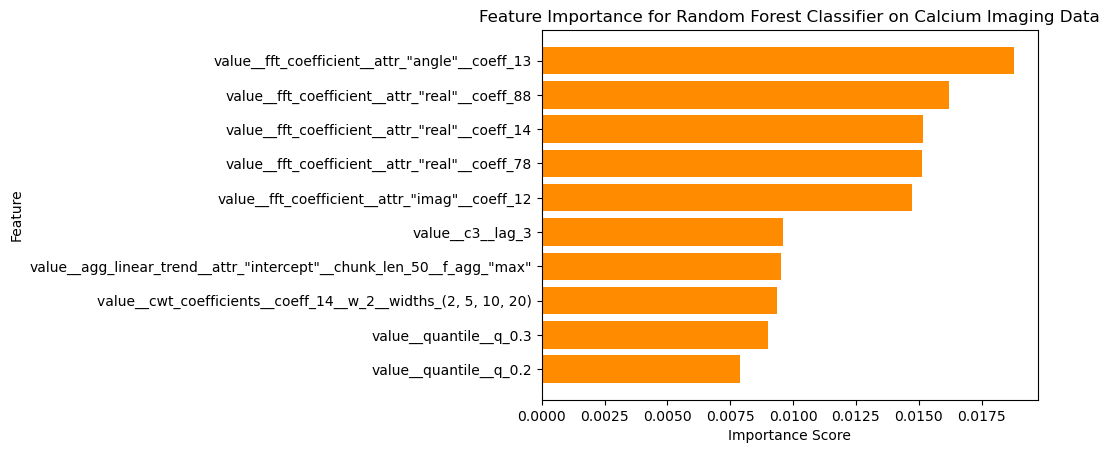

In [49]:
ci_features = ci_normalized_features.columns
ci_importances = ci_rf_clf.feature_importances_
ci_indices = np.argsort(ci_importances)

plt.barh(range(len(ci_indices))[-10:], ci_importances[ci_indices][-10:], color='#FF8C00')
plt.yticks(range(len(ci_indices))[-10:], [ci_features[i] for i in ci_indices][-10:])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest Classifier on Calcium Imaging Data")
plt.show()

## Learning Curve

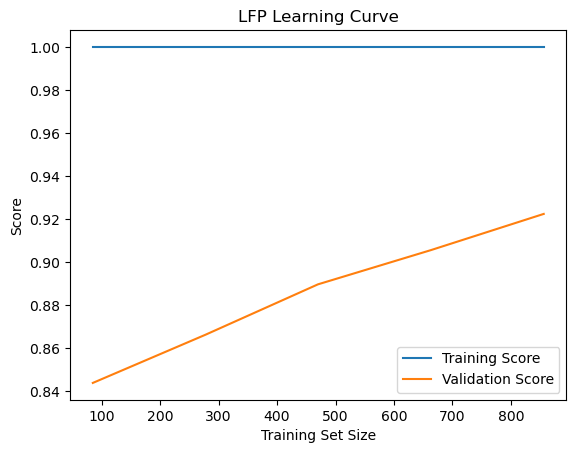

In [466]:
from sklearn.model_selection import learning_curve

lfp_train_sizes, lfp_train_scores, lfp_test_scores = learning_curve(lfp_rf_clf, lfp_X_train, lfp_y_train, cv=5)

plt.plot(lfp_train_sizes, np.mean(lfp_train_scores, axis=1), label="Training Score")
plt.plot(lfp_train_sizes, np.mean(lfp_test_scores, axis=1), label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.title("LFP Learning Curve")
plt.legend()
plt.show()